In [4]:
import sys
sys.path.insert(0, '../')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pyplr.CIE import get_CIES026
from pyplr.oceanops import predict_dark_counts, calibrated_radiance
from pyplr.stlab import get_led_colors
from pyplr.calibrate import CalibrationContext

colors = get_led_colors(rgb=True)

# Files for calibration data and random spectra

In [19]:
oo_spectra_fname = '../data/S2_oo_led_intensity_spectra.csv'
oo_info_fname = '../data/S2_oo_led_intensity_info.csv'

#oo_spectra_40_random_fname = '../data/oo_40_random_spectra_11-27-20-13-22.csv'
#oo_spectra_40_random_info_fname = '../data/oo_40_random_spectra_info_11-27-20-13-22.csv'

# Get calibrated radiance data

In [20]:
sss = get_CIES026(asdf=True)

# load Ocean Optics data
oo_spectra = pd.read_csv(oo_spectra_fname, index_col=['led','intensity'])
oo_spectra.reset_index(drop=True, inplace=True)
oo_info = pd.read_csv(oo_info_fname)

darkcal = pd.read_table('../data/oo_dark_cal.txt', skiprows=2, index_col=False)
oo_dark_counts = predict_dark_counts(oo_info, darkcal)
cal_per_wl = pd.read_csv('../data/oo_calibration.csv', header=None)
sensor_area_cm2 = pd.read_csv('../data/oo_sensorArea.csv', header=None)

# Call function
w_m2_nm = calibrated_radiance(
    oo_spectra, 
    oo_info, 
    oo_dark_counts,
    cal_per_wl, 
    sensor_area_cm2)

# Replace indices
w_m2_nm['led'] = oo_info['led']
w_m2_nm['intensity'] = oo_info['intensity']
w_m2_nm.set_index(['led', 'intensity'], inplace=True)
w_m2_nm.sort_index(inplace=True)
w_m2_nm.columns = sss.index.astype('int')
w_m2_nm = w_m2_nm.interpolate(axis=1)
w_m2_nm.to_csv('../data/corrected_oo_spectra.csv')

# Create calibration context

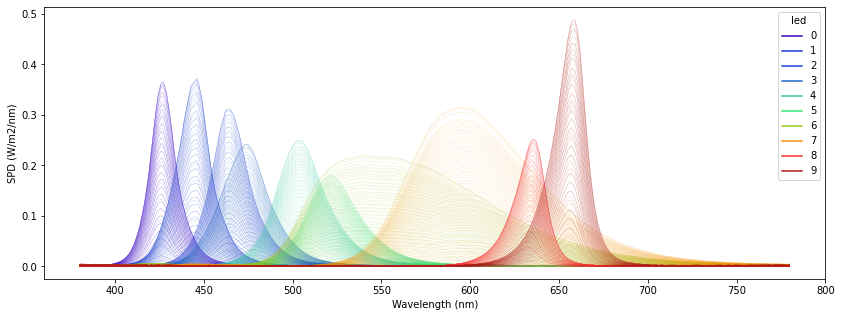

In [22]:
cc = CalibrationContext(data='../data/S1_corrected_oo_spectra.csv', binwidth=1)
fig = cc.plot_calibrated_spectra()

# Random spectra

In [20]:
# load Ocean Optics data
oo_test = pd.read_csv(oo_spectra_40_random_fname)
oo_test_info = pd.read_csv(oo_spectra_40_random_info_fname)

darkcal = pd.read_table('../data/oo_dark_cal.txt', skiprows=2, index_col=False)
oo_dark_counts = predict_dark_counts(oo_test_info, darkcal)
cal_per_wl = pd.read_csv('../data/oo_calibration.csv', header=None)
sensor_area_cm2 = pd.read_csv('../data/oo_sensorArea.csv', header=None)

# Call function
w_m2_nm = calibrated_radiance(oo_test, oo_test_info, oo_dark_counts, cal_per_wl, sensor_area_cm2)

# Replace indices
w_m2_nm.columns = sss.index.astype('int')

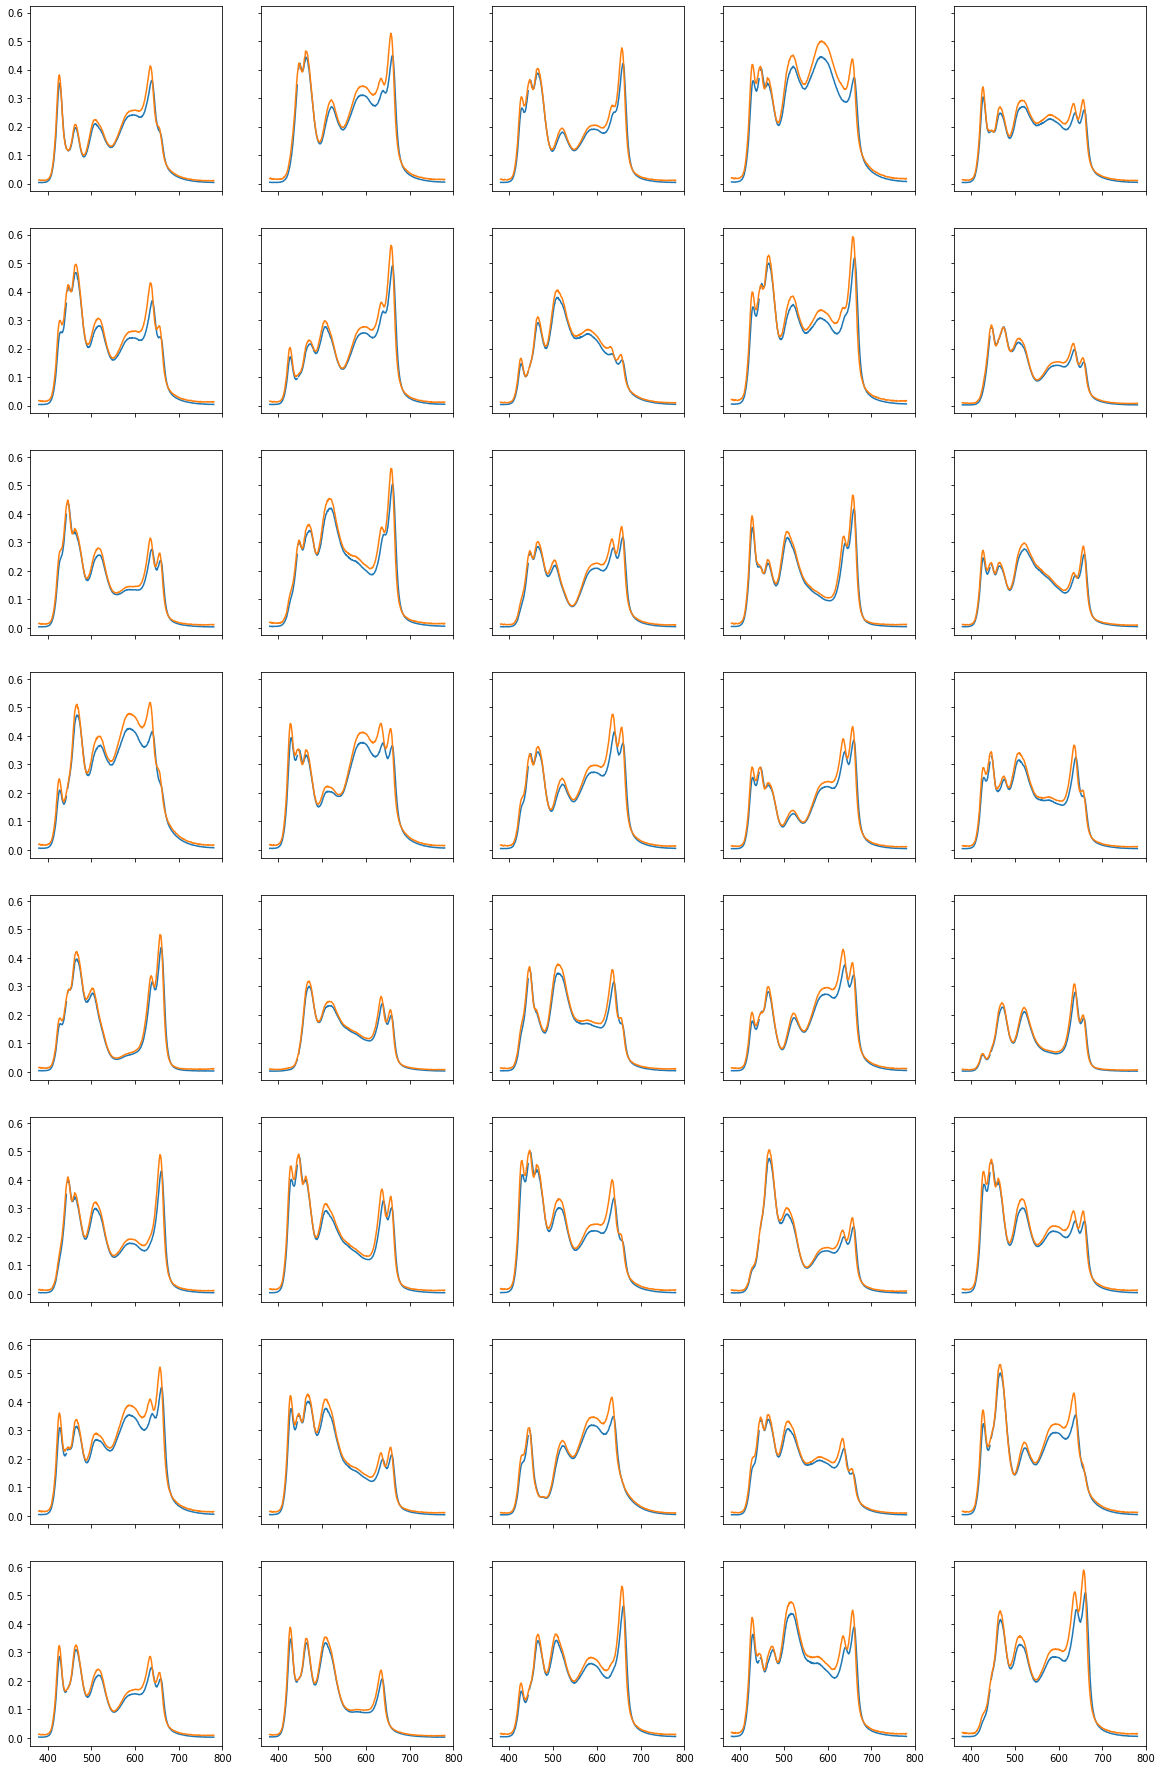

In [21]:
import ast

# set up fgiure
fig, axs = plt.subplots(nrows=8, ncols=5, figsize=(20,32), sharey=True, sharex=True)
axs = [ax for sublist in axs for ax in sublist]

# predict, measure and plot for 8 random inputs
for i, ax in enumerate(axs):
    pred = cc.predict_spd(ast.literal_eval(oo_test_info.loc[i,'intensities']))
    w_m2_nm.loc[i].plot(ax=ax)
    ax.plot(w_m2_nm.columns, pred)
# percent difference plot
# absolute power difference

In [9]:
def smlri_calculator(x, d):
    """
    x is 20 values, between 0 and 1
    Takes 20 values, corresponding to the values for the primaries in two scenarios. Scenario 1: low-mel, scenario: high-mel.
    x[0:9] -> low-mel
    x[10:19] -> high-mel
    """
    settings1 = x[0:9]
    settings2 = x[10:19]
    smlr1 = 0
    smlr2 = 0
    for ii in range(0, 9):
        idx1 = int(np.round(settings1[ii] * 4095))
        idx2 = int(np.round(settings2[ii] * 4095))
        smlr1 = smlr1 + d.loc[(ii, idx1)]
        smlr2 = smlr2 + d.loc[(ii, idx2)]
    return smlr1, smlr2

In [10]:
def melanopsin_contrast_calculator(x, d):
    smlr1, smlr2 = smlri_calculator(x, d)
    contrast = 1-pow((smlr2.Mel-smlr1.Mel)/smlr1.Mel, 2)
    return contrast

In [11]:
def cone_contrast_calculator(x, d):
    smlr1, smlr2 = smlri_calculator(x, d)
    contrast = np.array([(smlr2.S-smlr1.S)/smlr1.S, (smlr2.M-smlr1.M)/smlr1.M, (smlr2.L-smlr1.L)/smlr1.L])
    return contrast

In [ ]:
# Random start
x0 = np.random.rand(1, 20)[0]
from scipy.optimize import minimize

from scipy.optimize import Bounds
# Set up the bounds
bounds = Bounds(np.ones((20))*0, np.ones((20))*1)

cons = {'type': 'eq',
       'fun': lambda x, d: pow(cone_contrast_calculator(x, d), 2),
       'args': (d,)
       }

es = minimize(melanopsin_contrast_calculator, x0, method='trust-constr', args=d, constraints=cons, options={'verbose': 1, 'maxiter' : 5000}, bounds=bounds)

KeyboardInterrupt: 

In [14]:
#melanopsin_contrast_calculator(es.x, d), cone_contrast_calculator(es.x, d)


(-0.0004183014800037471, array([0.05171784, 0.02871645, 0.03869218]))